#### RL Course by David Silver

## Lecture 5 Model-Free Control

- On-Policy Monte-Carlo Control
- On-Policy Temporal-Difference Learing
- Off-Policy Learning

In [13]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 Monte-Carlo Control

<img src="img/04_MC control.png" width=60%>

采用$\epsilon-greedy$方式学习的最终策略, 依然是一个$epsilon-greedy$的策略. 如何保证不会丢到一个更好的策略,同时当我们得到一个当前的最好策略不想继续探索的时候, 得到的这个策略是一个确定性策略,而不包含随机行为? 由此引出了GLIE的概念.

GLIE(greedy in limit with Infinite Exploration)要求学习方法有两个条件
- 充分探索: 当迭代次数趋向无穷时, 所有状态-动作对都被探索无数次
- 最优收敛: 策略收敛在一个贪婪策略,不再具有随机性

满足GLIE的方法, 就能够达到我们上述的学习目的. 
对于$\epsilon-greedy$方法而言, 当$\epsilon = \frac{1}{k}$时, 就满足GLIE.

In [14]:
def improve_greedy_policy(Q, epsilon, nA):
    def policy(state):
        prob = np.ones(nA) * epsilon / nA
        prob[np.argmax(Q[state])] += 1 - epsilon
        return prob
    return policy

def improve_glie_greedy_policy(Q, nA):
    def policy(state, i_episode):
        epsilon = 1. / (10 + i_episode/1000)
        prob = np.ones(nA) * epsilon / nA
        prob[np.argmax(Q[state])] += 1 - epsilon
        return prob
    return policy

In [15]:
# GLIE Monte-Carlo Control
from collections import deque, Counter, defaultdict


def GLIE_MC(MDP, episods, gamma = 1.):
    '''GLIE Monte-Carlo control method. Use epsilon-greedy for improvement with a decent epsilon.
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
    
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    N = defaultdict(lambda: np.zeros(MDP.action_space.n))
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    
    for i_episod in range(1, episods+1):
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end='')
        episod = deque()
        G = 0
        s = MDP.reset()
#         policy = improve_glie_greedy_policy(Q, MDP.action_space.n)
        policy = improve_greedy_policy(Q, 0.1, MDP.action_space.n)
        done = False
        while not done: # run the simulation
            prob = policy(s)
#             prob = policy(s, i_episod)
            a = np.random.choice(np.arange(len(prob)), p=prob)
            s_n, r, done, _ = MDP.step(a)
            episod.append((s, a, r))
            s = s_n
        while len(episod) != 0: # update value evaluation of every-visit
            s, a, r = episod.pop()
            G = r + gamma * G
            N[s][a] += 1
            Q[s][a] += (G - Q[s][a])/N[s][a]
#         policy = improve_greedy_policy(Q, 1./i_episod, MDP.action_space.n) # update epsilon for descent.
    return Q

## 2 On-Policy TD Learning

TD方法具有低方差, 在线学习, 可以学习不完整的序列的特点, 因此可以利用TD代替MC进行更有效的学习,在TD学习中, 同样使用Q作为估计值, 使用$\epsilon-greedy$作为策略进行优化, 在每个时间步对Q值进行更新.

TD的更新结构如下, 由其状态序列得名Sarsa
<img src="img/sarsa_structure.png">

sarsa的算法流程如下:
<img src="img/sarsa.png">

In [23]:
# Sarsa Algorithm
from collections import defaultdict

def Sarsa(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3):
    '''Sarsa Algorithm for On-policy Control
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    policy = improve_greedy_policy(Q, epsilon, MDP.action_space.n)
    step = 0
    converge = []
    step = 0
    for i_episod in range(1, episods+1):
        if i_episod % 100000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        s = MDP.reset()
        done = False
        prob = policy(s)
        a = np.random.choice(np.arange(len(prob)), p = prob)
        while not done:
            step += 1
            s_next, r, done, _ = MDP.step(a)
            if not done:
                prob = policy(s_next)
                a_next = np.random.choice(np.arange(len(prob)), p = prob)
                Q[s][a] += alpha * (r + gamma * Q[s_next][a_next] - Q[s][a])
                s = s_next
                a = a_next
            else:
                Q[s][a] += alpha * (r + gamma * 0 - Q[s][a]) # Q(terminate-state,.) = 0
        converge.append(step)
        step = 0
    return Q, converge

有上一讲可知, TD(0)只学习了前一步的估值, 由此可以衍生出n-step的TD, 进而衍生出将0到n步状态估值结合的TD($\lambda$). 前向的TD($\lambda$)需要向MC一样知道后面的状态, 而后向的TD($\lambda$)利用资格轨迹将当前步的TD Error向后传播,达到更新的目的, 以下是加入了后向传播的TD($\lambda$)的sarsa($\lambda$)

In [35]:
# Sarsa(lambda) Algorithm
from collections import defaultdict

def Sarsa_lambda(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3, lamda = 0.5):
    '''Sarsa Lambda with Backward view
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        lamda: parameter of sarsa lamda, the decay rate of n-step TD
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    
    policy = improve_greedy_policy(Q, epsilon, MDP.action_space.n)
    converge = []
    step = 0
    for i_episod in range(1, episods+1):
        E = defaultdict(lambda: np.zeros(MDP.action_space.n)) # eligibility trace
        
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        
        s = MDP.reset()
        done = False
        prob = policy(s)
        a = np.random.choice(np.arange(len(prob)), p = prob)
        while not done:
            step += 1
            s_next, r, done, _ = MDP.step(a)
            E[s][a] += 1
            
            if not done:
                prob = policy(s_next)
                a_next = np.random.choice(np.arange(len(prob)), p = prob)
                td_error = r + gamma * Q[s_next][a_next] - Q[s][a]
                
                for state in E.keys():
                    Q[state] += alpha * td_error * E[state]
                    E[state] = E[state] * lamda
                
                s = s_next
                a = a_next
            else:
                td_error = r + gamma * 0 - Q[s][a]
                for state in E.keys():
                    Q[state] += alpha * td_error * E[state]
                    E[state] = E[state] * lamda
        converge.append(step)
        step = 0
    return Q, converge

## 3 Off-Policy Learning

off-policy指的是通过$\mu$策略(表现策略)与环境交互,得到S,A,R的序列作为经验, 利用经验评价和优化另一个策略$\pi$的学习方式.

off-policy的重要性:
- 从人类经验或其他agent的经验学习和优化自己的策略
- 重用旧的策略$\pi_1$,$\pi_2$,...,$\pi_{t-1}$产生的经验
- 从一个策略获取经验训练多个策略

off-policy的可行性:
- 通过重要性采样使用经验
- 重要性采样是用于估计不同分布的期望的方法, 表示如下
<img src="img/importance_sample.png" width=60%>
- 对Monte-Carlo方法使用重要性采样
<img src="img/mc_is.png">
- 对TD-learning方法使用重要性采样
<img src="img/td_is.png">

由式可见, 对于MC使用重要性采样,随着序列长度的增加, 方差会急剧增加, 使得采样结果有误甚至毫无意义. 但是对TD使用重要性采样, 只需要进行一次估计, 方差更低, 更有使用价值.

### Q-learning
- 不使用重要性采样
- 使用基于Q值的$\epsilon-greedy$进行探索
- 使用greedy对Q进行优化
- greedy策略和$\epsilon-greedy$一起提高
- intuition, 使用$\epsilon-greedy$方法选择下一个动作, 到达$S'$后, 假设能够从$S'$选择最优的途径继续(即采用Q(S',.)的最大估计)作为更新q(s,a)的依据.
<img src="img/q_learning_structure.png">

具体算法流程如下:
<img src="img/Q_learning.png">

In [42]:
# Q_learning Algorithm
from collections import defaultdict

def Q_Learning(MDP, episods, gamma = 1, alpha = 0.1, epsilon = 0.3):
    '''Q_Learning Algorithm for Off-policy Control
    
    Params:
        MDP: an instance of MDP
        episods: number of episod
        gamma: decay of reward
        alpha: parameter of TD-learning, learning rate
        epsilon: parameter of epsilon-greedy
        
    Return:
        Q, A defaultdict(np.ndarray)
        Q[state][value]: the estimate expect of state-action pair
    '''
    Q = defaultdict(lambda: np.zeros(MDP.action_space.n))
    policy = improve_greedy_policy(Q, epsilon, MDP.action_space.n)
    converge = []
    step = 0
    for i_episod in range(1, episods+1):
        if i_episod % 1000 == 0:
            print("\ri_episod:%d/%d"%(i_episod, episods), end="")
        
        s = MDP.reset()
        done = False
        
        while not done:
            step += 1
            prob = policy(s)
            a = np.random.choice(np.arange(len(prob)), p = prob)
            s_next, r, done, _ = MDP.step(a)
            if not done:
                Q[s][a] += alpha * (r + gamma * np.max(Q[s_next]) - Q[s][a])
                s = s_next
            else:
                Q[s][a] += alpha * (r + 0 - Q[s][a]) # Q(terminate-state,.) = 0
        converge.append(step)
        step = 0
    return Q, converge

## 4 实验

### 4.1 利用MC Control学习Blackjack中的最优策略

In [19]:
from lib.envs.blackjack import BlackjackEnv
import matplotlib
matplotlib.style.use('ggplot')

def plot_bj_value_function(Q, title):
    V = defaultdict(float)
    for s in Q.keys():
        V[s] = np.max(Q[s])
    max_x = max(x[0] for x in V)
    min_x = min(x[0] for x in V)
    max_y = max(x[1] for x in V)
    min_y = min(x[1] for x in V)
    
    x = np.arange(min_x, max_x+1)           # 生成 x 坐标，表示玩家此刻的点数
    y = np.arange(min_y, max_y+1)             # 生成 y 坐标，表示庄家的明牌
    X, Y = np.meshgrid(x, y)        # 生成 meshgrid
    # 画图
    Z_nace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    fig = plt.figure()
    ax1 = fig.add_subplot(211, projection='3d')
    ax1.plot_surface(X, Y, Z_nace, cmap=matplotlib.cm.coolwarm, vmin=-1, vmax=1,rstride = 1 , cstride = 1)
    ax1.view_init(ax1.elev, -120)
    ax1.set_title("No usable ace")
    ax1.set_xlabel('Player\'s point')
    ax1.set_ylabel('Deal\'s face-up card')
    ax2 = fig.add_subplot(212, projection='3d')
    ax2.plot_surface(X, Y, Z_ace, cmap=matplotlib.cm.coolwarm, vmin=-1, vmax=1,rstride = 1 , cstride = 1)
    ax2.view_init(ax1.elev, -120)
    ax2.set_title("Usable ace")
    ax2.set_xlabel('Player\'s point')
    ax2.set_ylabel('Deal\'s face-up card')
    fig.show()    

def plot_policy(Q, tittle):
    V = defaultdict(float)
    for s in Q.keys():
        V[s] = np.argmax(Q[s])
    max_x = max(x[0] for x in V)
    min_x = min(x[0] for x in V)
    max_y = max(x[1] for x in V)
    min_y = min(x[1] for x in V)
    x = np.arange(min_x, max_x+1)
    y = np.arange(min_y, max_y+1)
    print('No Usable')
    print('  ', end='')
    for n in y:
        print(n, end=' ')
    print()
    for m in x:
        print(m, end=' ')
        for n in y:
            print('x' if V[(m, n, False)] == 1 else 'o', end=' ')
        print()
    print('\nUsable')
    print('  ', end='')
    for n in y:
        print(n, end=' ')
    print()
    for m in x:
        print(m, end = ' ')
        for n in y:
            print('x' if V[(m, n, True)] == 1 else 'o', end=' ')
        print()

env = BlackjackEnv()
env.reset()

(21, 2, True)

In [20]:
Q_glie = GLIE_MC(env, 500000)

i_episod:500000/500000

<IPython.core.display.Javascript object>


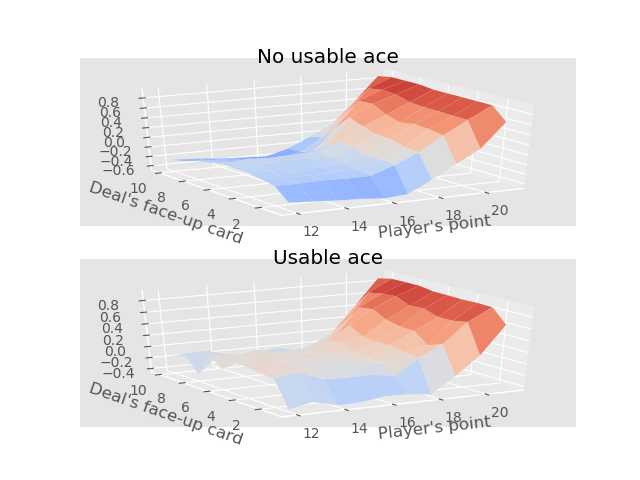

In [21]:
plot_bj_value_function(Q_glie, 'mc_100k')

In [22]:
plot_policy(Q_glie, 'title')

No Usable
  1 2 3 4 5 6 7 8 9 10 
12 x o o o o x x x x x 
13 x o o o o o x x x x 
14 x o o x o o x x x x 
15 x o o o o o x x x x 
16 x o o o o o x x o o 
17 o o o o o o o o o o 
18 o o o o o o o o o o 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 

Usable
  1 2 3 4 5 6 7 8 9 10 
12 x x x x x o x x x x 
13 x x x x x x x x x x 
14 x x x x x x x x x x 
15 x x x x x x x x x x 
16 x x x x x x x x x x 
17 x o x x x x x x x x 
18 x o o o o o o o x x 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 


### 4.2 利用sarsa学习blackjack

In [97]:
Q_sarsa,_ = Sarsa(env, 1000000, epsilon = 0.1)

i_episod:1000000/1000000

<IPython.core.display.Javascript object>


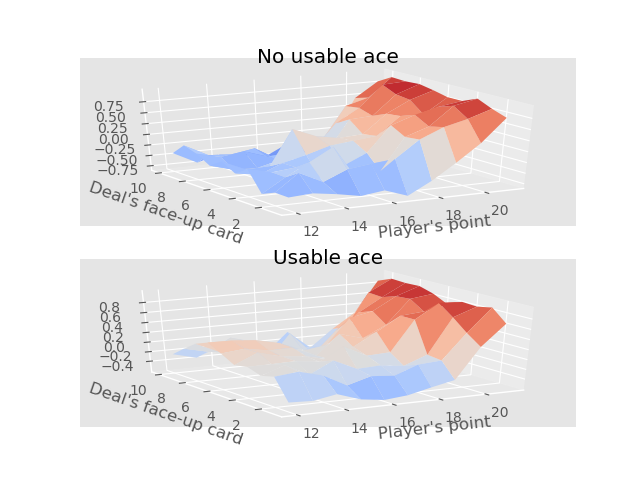

In [98]:
plot_bj_value_function(Q_sarsa, 'sarsa_1kk')

In [99]:
plot_policy(Q_sarsa, 'sarsa_1kk')

No Usable
  1 2 3 4 5 6 7 8 9 10 
12 x x x x x x x x x x 
13 x o x o x x x x o x 
14 x o x o x x o x x x 
15 x x o o o o x x o x 
16 o o o x o o o x x o 
17 o o o o o o o o o o 
18 o o o o o o o o o o 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 

Usable
  1 2 3 4 5 6 7 8 9 10 
12 x x x x x x x x x x 
13 x x x x x x x x x x 
14 x x x x x x x x x x 
15 x x x x x o x x x x 
16 x x x x x x x x x x 
17 x x o x x x x x x x 
18 x o x x o x o o x x 
19 x x x o o o o o x x 
20 o o o o o o o o o o 
21 o o o o o o o o o o 


In [40]:
Q_sarsa_lambda, _ = Sarsa_lambda(env, 100000)

i_episod:100000/100000

<IPython.core.display.Javascript object>


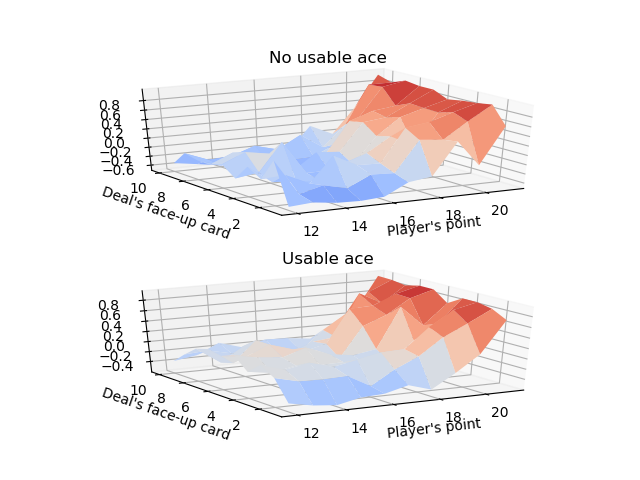

In [41]:
plot_bj_value_function(Q_sarsa_lambda, 'sarsa_lambda_100k')

In [42]:
plot_policy(Q_sarsa_lambda, 'sarsa_lambda')

No Usable
  1 2 3 4 5 6 7 8 9 10 
12 x o o o o x x x x x 
13 x o o x x o x x x x 
14 x o x x o x x o x x 
15 x x o x o o x x x o 
16 x x x o o o x x x x 
17 x o o o o o o o o o 
18 o o o o o o o o o o 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 

Usable
  1 2 3 4 5 6 7 8 9 10 
12 x x x x x x x x x x 
13 x x x x x x x x x x 
14 x o x x x x x x x x 
15 x o x x o x x x x x 
16 x x x x x o x x x x 
17 x x x x x x x x x x 
18 x o o o x o o x o x 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 


### 4.3 利用Q-learning 学习blackjack

In [102]:
Q_ql,_ = Q_Learning(env, 500000)

i_episod:500000/500000

<IPython.core.display.Javascript object>


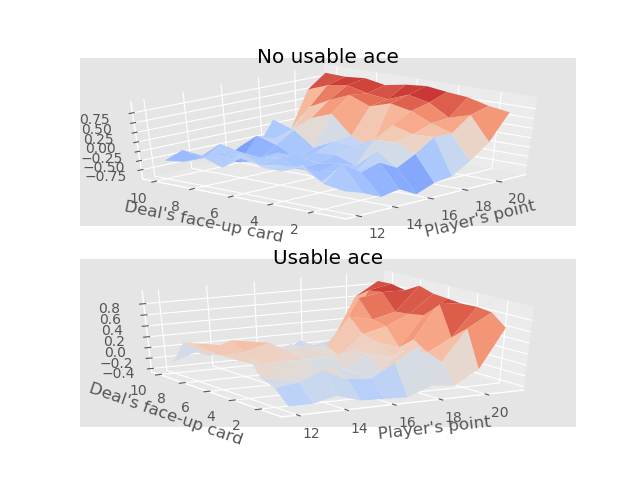

In [103]:
plot_bj_value_function(Q_ql, 'q_learning_1kk')

In [104]:
plot_policy(Q_ql, 'qlearning')

No Usable
  1 2 3 4 5 6 7 8 9 10 
12 x o x o x x x o o x 
13 x o x o o x x x x x 
14 x o o x o x x x x x 
15 x o o o x x o x x o 
16 o o o o o o x x x x 
17 x o o o o o o o x o 
18 o o o o o o o o o o 
19 o o o o o o o o o o 
20 o o o o o o o o o o 
21 o o o o o o o o o o 

Usable
  1 2 3 4 5 6 7 8 9 10 
12 x x x x x x x x x x 
13 x x x x o x x x x x 
14 x x x x x x x x x x 
15 x x x x x x x x x x 
16 x x x x o x x x x x 
17 x x x x x x x o x x 
18 o o o o o x o o x x 
19 x x x o x o o o x x 
20 o o x o o o o o o o 
21 o o o o o o o o o o 


## 4.4 Windy Gridworld Example

通过该示例比较sarsa的学习速度

**问题描述**

- 当agent进入某个格子时， 会受到箭头方向的风，向箭头方向移动k格
- agent不知边界的存在， 不知前后格之间相对关系， 不清楚起始点二维位置
- 能够记住曾经在什么时间步经过某一个格子

<img src="img/WindyGridWorld.png">

In [117]:
from lib.envs.windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
def plot_convergence(convergence, title, fig=None, *arg):
    if fig == None:
        fig = plt.figure()
        fig.clear()
        fig.suptitle(title)
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(arg[0])
    x = np.arange(0, len(convergence))
    y = np.asarray(convergence)
    ax.plot(x, y)
    ax.set_xlabel("Num of episodes")
    ax.set_ylabel("Steps per episode")
    ax.set_title("Convergence")

def plot_step(convergence, title, fig = None, *arg):
    arr = np.array(convergence).cumsum(0)
    z = np.zeros(arr[-1])
    arr_i = 0
    for i in range(z.size):
        if i < arr[arr_i]:
            z[i] = arr_i
        else:
            arr_i += 1
            z[i] = arr_i
    if fig is None:
        fig = plt.figure()
        fig.suptitle(title)
        ax = fig.add_subplot(111)
    else:
        ax = fig.add_subplot(arg[0])
    ax.plot(np.arange(z.size), z)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Episodes")
    ax.set_title("Episodes per step")
    

In [122]:
Q, converge0 = Sarsa(env, 200, epsilon=0.1)
Q, converge1 = Sarsa_lambda(env, 200, epsilon=0.1)

<IPython.core.display.Javascript object>


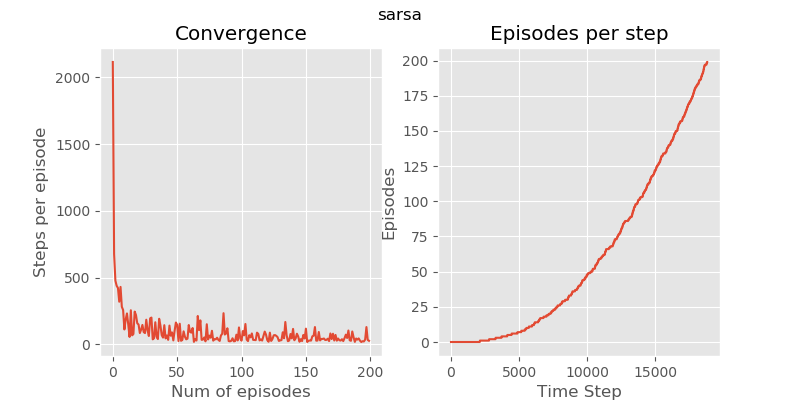

<IPython.core.display.Javascript object>


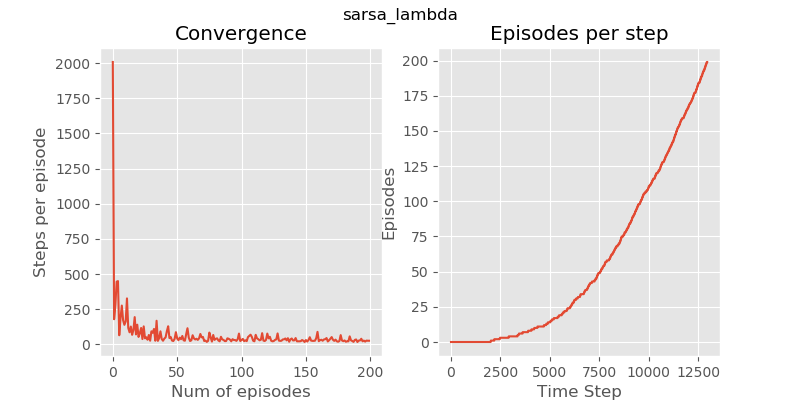

In [123]:
fig =plt.figure(figsize = (8,4))
fig.suptitle('sarsa')
plot_convergence(converge0, 'sarsa', fig, 121)
plot_step(converge0, 'sarsa', fig, 122)
fig1 = plt.figure(figsize = (8,4))
fig1.suptitle('sarsa_lambda')
plot_convergence(converge1, 'sarsa', fig1, 121)
plot_step(converge1, 'sarsa', fig1, 122)